# Imports

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy
from sklearn.model_selection import GridSearchCV

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# Functions

In [12]:
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = SVC()
    
    param_grid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search
  
def sentiment_score(review, tokenizer, model):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits)) +1

# EDA Analysis

In [3]:
filename = "/Users/test/Downloads/Tweets.csv"

In [6]:
df_ = pd.read_csv(filename)
df_

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [7]:
df = df_[["text",'airline_sentiment']].copy()
df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [8]:
text_mapping = {"positive":1, 'neutral':0, "negative":2}

df['target'] = df['airline_sentiment'].map(text_mapping)

In [9]:
df

,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,0
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0
3,@VirginAmerica it's really aggressive to blast...,negative,2
4,@VirginAmerica and it's a really big bad thing...,negative,2
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,1
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,2
14637,@AmericanAir Please bring American Airlines to...,neutral,0
14638,"@AmericanAir you have my money, you change my ...",negative,2


In [11]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [13]:
df["berta_model"] = df["text"].apply(lambda review: sentiment_score(review, tokenizer, model))

In [14]:
df

,text,airline_sentiment,target,berta_model
0,@VirginAmerica What @dhepburn said.,neutral,0,5
1,@VirginAmerica plus you've added commercials t...,positive,1,5
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0,1
3,@VirginAmerica it's really aggressive to blast...,negative,2,4
4,@VirginAmerica and it's a really big bad thing...,negative,2,1
...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,1,5
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,2,1
14637,@AmericanAir Please bring American Airlines to...,neutral,0,1
14638,"@AmericanAir you have my money, you change my ...",negative,2,1


<Axes: xlabel='berta_model'>

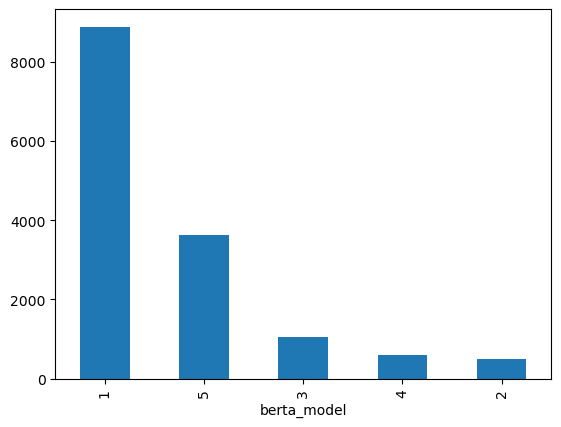

In [15]:
df["berta_model"].value_counts().plot.bar()

In [16]:
df["berta_model"].value_counts()

berta_model
1    8878
5    3621
3    1061
4     593
2     487
Name: count, dtype: int64

In [17]:
df["target"].value_counts()

target
2    9178
0    3099
1    2363
Name: count, dtype: int64